In [61]:
import os
import mido
import utils ##
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [62]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\Jafet Velásquez Luna\\Documents\\Cursos\\Dip - IA Aplicada\\Proyecto Final\\hum_transcription_Project_DIA\\utils\\__init__.py'>

# Importar MIDI info

In [63]:
df_midis_info = pd.read_csv('datos_procesados/midis/midis_info.csv', index_col=0)
df_midis_notas = pd.read_csv('datos_procesados/midis/midis_notas.csv', index_col=0)

In [64]:
# Tipos de MIDI
df_non_standard = pd.read_csv('datos_procesados/midis/tipos/no_estandar.csv', index_col=0)
df_standard = pd.read_csv('datos_procesados/midis/tipos/estandar.csv', index_col=0)

In [65]:
df_midi = df_standard.merge(df_midis_info, how='left', left_index=True, right_index=True)
df_midi = df_midi.drop(columns=['problem?'])
df_midi = df_midi.rename({'velocity':'velocity_start'}, axis=1)

In [66]:
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


# Extraer datos

## Onsets
Onset hace referencia al inicio de un sonido o una nota musical. Se pueden detectar con el incremento de la amplitud de las ondas o con métodos más sofisticados. En este caso, ya que el objetivo emparejar la `ejecución de las notas de tarareos` con su ejecución en MIDI, se buscará el primer **onset** y se emparejará con el inicio del primer `note_on` con $\text{velocity} = 0$ del MIDI.

In [ ]:
# path_carpeta = 'datos/Tarareos/wav_data_sync_with_midi/'
# first_onset = []

# for filename in os.listdir(path_carpeta):
#     path_archivo = os.path.join(path_carpeta, filename)
    

[Text(0.5, 0, 'time'), Text(0, 0.5, 'E')]

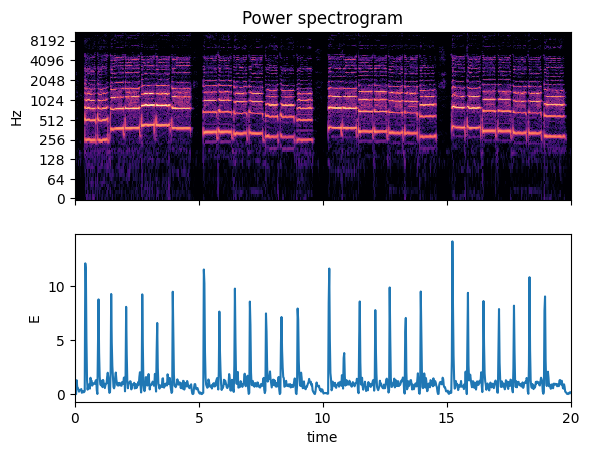

In [44]:
import matplotlib.pyplot as plt

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path)

o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].set(xlabel='time', ylabel='E')


[Text(0.5, 0, 'time'), Text(0, 0.5, 'E')]

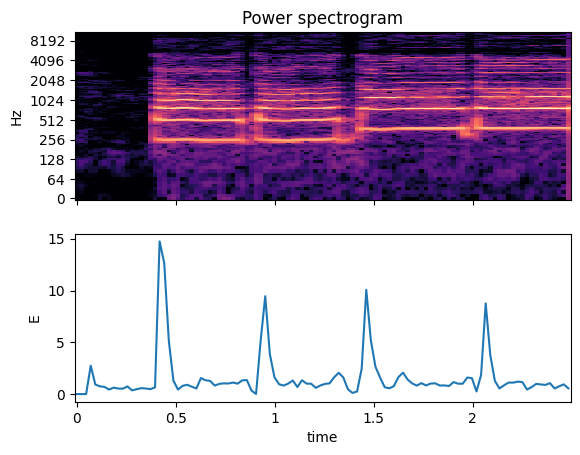

In [48]:
import matplotlib.pyplot as plt

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path)

o_env = librosa.onset.onset_strength(y=y[:len(y)//8], sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y[:len(y)//8]))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].set(xlabel='time', ylabel='E')


In [49]:
from scipy.signal import butter, sosfilt

# Definir el filtro de paso banda (band-pass)
lowcut = 18.35404799483797  # Frecuencia mínima en Hz
highcut = 1166.5738482488446  # Frecuencia máxima en Hz
fs = 22050  # Frecuencia de muestreo

# Diseñar filtro Butterworth
sos = butter(10, [lowcut, highcut], btype='band', fs=fs, output='sos',)

# Aplicar filtro
y_filtered = sosfilt(sos, y)


[Text(0.5, 0, 'time'), Text(0, 0.5, 'E')]

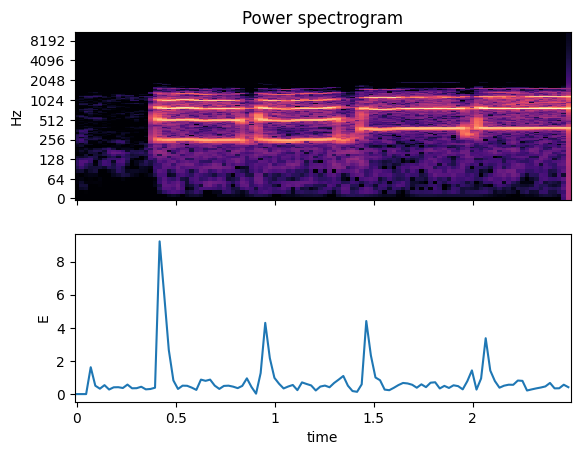

In [60]:
y = y_filtered
o_env = librosa.onset.onset_strength(y=y[:len(y)//8], sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y[:len(y)//8]))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].set(xlabel='time', ylabel='E')


## Reducir dimensión de frecuencias

Frecuencia máxima utilizable: $1167$ Hz

In [81]:
audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
min_freq = 18
max_freq = 1167

- Muestra original

Dimensiones audio:  (1025, 1723)


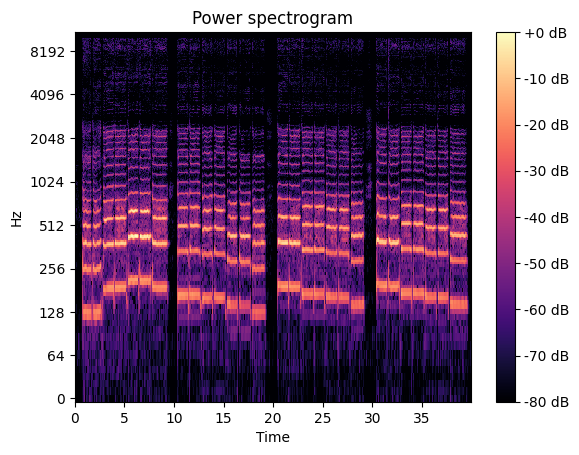

In [85]:
y, sr = librosa.load(audio_path, sr = None)
S = np.abs(librosa.stft(y))
print('Dimensiones audio: ', S.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

- Resampleando al importar

Dimensiones audio:  (1025, 92)


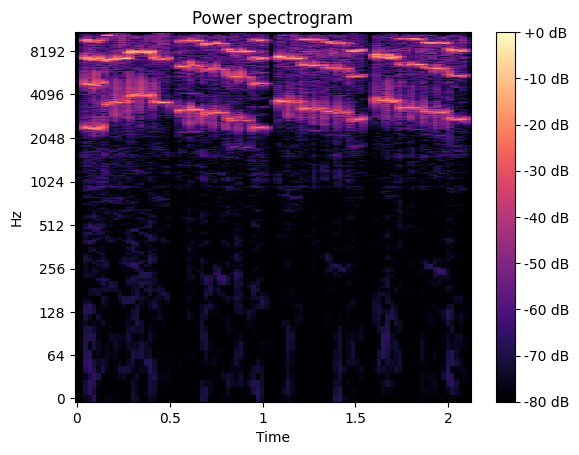

In [113]:
y, sr = librosa.load(audio_path, sr = 2*max_freq)
S = np.abs(librosa.stft(y))
print('Dimensiones audio: ', S.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

- Cortando el array

Dimensiones audio:  (53, 1723)


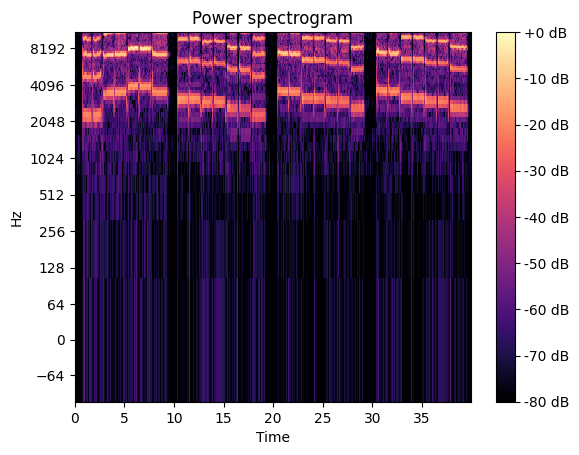

In [96]:
y, sr = librosa.load(audio_path, sr=None)
S = librosa.stft(y)
S_magnitude = np.abs(S)

freqs = librosa.fft_frequencies(sr=sr)

# Obtener los índices que corresponden a estas frecuencias
min_index = np.argmax(freqs >= min_freq)
max_index = np.argmax(freqs > max_freq) - 1
S_filtered = S_magnitude[min_index:max_index, :]
print('Dimensiones audio: ', S_filtered.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_filtered,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## Reducir dimensión de tiempos

Se busca una longitud temporal de ventana tan pequeña como para capturar la nota más corta, y lo suficientemente amplia para reducir el número de elementos de la dimensión temporal.

### Muestras/ventana

In [111]:
audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


In [114]:
y, sr = librosa.load(audio_path, sr=None)

- L (duración de ventana) a muestras

In [124]:
# Convertir la duración de la ventana (L en segundos) a muestras por ventana
L_segs = lowest_time/2 # Doble precisión
L = int(sr * L_segs) 
print(L, "muestras/ventana")

# Dividir la señal de audio en ventanas de longitud L
audio_frames = librosa.util.frame(y, frame_length=L, hop_length=L)
print('(muestras, ventanas): ', audio_frames.shape)

2756 muestras/ventana
(muestras, ventanas):  (2756, 320)


In [117]:
print('Ventanas audio real', librosa.get_duration(y=y, sr=sr) / (lowest_time/2))
print('Ventanas audio real', librosa.get_duration(y=y, sr=sr) / lowest_time)

Ventanas audio real 320.0
Ventanas audio real 160.0


- Test

In [184]:
y_foo = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]).astype(float)
sr_foo = 4
low_time_foo = 0.5
L_foo = int(sr_foo * low_time_foo) #(sr * lowest_time)


frames_foo = librosa.util.frame(y_foo, frame_length=L_foo, hop_length=L_foo, axis=-1)
print(frames_foo.shape)
frames_foo
# L es la dimensión [0] del resultado
# N es la dimensión [1] del resultado
# y.shape[0] debe ser divisible por L para no perder información

(2, 10)


array([[ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.],
       [ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.]])

In [187]:
S_foo = librosa.stft(y_foo, n_fft=L_foo, hop_length=L_foo)
S_magnitud_foo = np.abs(S_foo)
print(S_magnitud_foo.shape)

(2, 11)


In [51]:
# Realizar STFT
stft_result = librosa.stft(y_foo, n_fft=L_foo, hop_length=L_foo)

# Obtener el espectrograma con N ventanas
spectrogram = np.abs(stft_result)

### Umbral de tiempo

In [139]:
audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


- 5 segundos

In [140]:
y, sr = librosa.load(audio_path, sr=None, duration=5)

In [142]:
L_segs = lowest_time/2
L = int(sr * L_segs)

# Dividir la señal de audio en ventanas de longitud L
audio_frames = librosa.util.frame(y, frame_length=L, hop_length=L)
print('(muestras, ventanas): ', audio_frames.shape)

(muestras, ventanas):  (2756, 80)


- 10 segundos

In [143]:
y, sr = librosa.load(audio_path, sr=None, duration=10)

In [144]:
L_segs = lowest_time/2
L = int(sr * L_segs)

# Dividir la señal de audio en ventanas de longitud L
audio_frames = librosa.util.frame(y, frame_length=L, hop_length=L)
print('(muestras, ventanas): ', audio_frames.shape)

(muestras, ventanas):  (2756, 160)


- 15 segundos

In [145]:
y, sr = librosa.load(audio_path, sr=None, duration=15)

In [146]:
L_segs = lowest_time/2
L = int(sr * L_segs)

# Dividir la señal de audio en ventanas de longitud L
audio_frames = librosa.util.frame(y, frame_length=L, hop_length=L)
print('(muestras, ventanas): ', audio_frames.shape)

(muestras, ventanas):  (2756, 240)


---

## Reducción conjunta

Se combinan las siguientes reducciones:
- `Frecuencia`: Por bandas de frecuencias (máxima frecuencia de muestreo con recorte de array).
- `Muestras/ventana`: Ventanas de 50% la duración de la nota más corta.
- `Umbral de tiempo`: 10 segundos duración máxima de audio.

In [192]:
audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


- Umbral de tiempo

In [193]:
y, sr = librosa.load(audio_path, sr=None, duration=10)

- Muestras/ventana

In [201]:
L_segs = lowest_time/2
L = int(sr * L_segs)

# Frames para análisis dimensión T
audio_frames = librosa.util.frame(y, frame_length=L, hop_length=L)
print('(muestras, ventanas): ', audio_frames.shape)

# Frames para espectrograma
S = librosa.stft(y, n_fft=L, hop_length=L)
S_magnitude = np.abs(S)

(muestras, ventanas):  (2756, 160)


- Frecuencia

In [175]:
freqs = librosa.fft_frequencies(sr=sr, n_fft=L)

# Obtener los índices que corresponden a estas frecuencias
min_index = np.argmax(freqs >= min_freq)
max_index = np.argmax(freqs > max_freq) - 1
S_filtered = S_magnitude[min_index:max_index, :]

Dimensiones audio:  (70, 161)


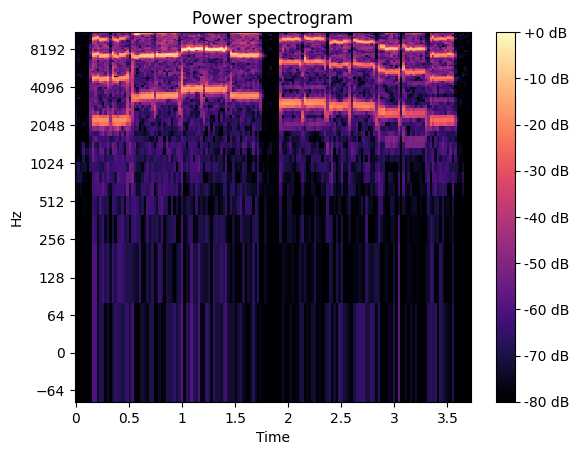

In [177]:
# Espectrograma
print('Dimensiones audio: ', S_filtered.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_filtered,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")